# Part 1 

We first try and create a simple MLP and see how it performs on the CIFAR dataset, after which we shall compare it with a modified MLP with simple skip connections.



In [ ]:
#importing the required modules
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
from torch.utils.data import random_split
import numpy as np

In [ ]:
train_dataset_CIFAR = dsets.CIFAR10(root = './',train = True, transform = transforms.ToTensor(),download = True)
train_dataset_MNIST = dsets.MNIST(root = './',train = True, transform = transforms.ToTensor(),download = True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
test_dataset_CIFAR = dsets.CIFAR10(root = './',train = False , transform = transforms.ToTensor(),download = True)
test_dataset_MNIST = dsets.MNIST(root = './',train = False , transform = transforms.ToTensor(),download = True)

Files already downloaded and verified


In [ ]:
#we split the training data into training and validation set
torch.manual_seed(43)
val_size = 5000

train_size_CIFAR = len(train_dataset_CIFAR) - val_size
train_size_MNIST = len(train_dataset_MNIST) - val_size

train_dataset_CIFAR, val_dataset_CIFAR = random_split(train_dataset_CIFAR, [train_size_CIFAR, val_size])
train_dataset_MNIST,val_dataset_MNIST =  random_split(train_dataset_MNIST, [train_size_MNIST, val_size])

In [ ]:
#understanding the dimensions of the data
print(train_dataset_CIFAR[0][0].size())
print(train_dataset_MNIST[0][1])
# we have an imput image given by a 28x28 matrix and a label which in this case is 5

torch.Size([3, 32, 32])
5


In [ ]:
#we now load segment the data into batches
batch_size = 100
train_loader_CIFAR = torch.utils.data.DataLoader(dataset = train_dataset_CIFAR,batch_size = batch_size , shuffle = True)
test_loader_CIFAR = torch.utils.data.DataLoader(dataset = test_dataset_CIFAR , batch_size = batch_size , shuffle = False)
train_loader_MNIST = torch.utils.data.DataLoader(dataset = train_dataset_MNIST,batch_size = batch_size , shuffle = True)
test_loader_MNIST = torch.utils.data.DataLoader(dataset = test_dataset_MNIST , batch_size = batch_size , shuffle = False)
validation_loader_MNIST = torch.utils.data.DataLoader(dataset = val_dataset_MNIST,batch_size = batch_size , shuffle = True)
validation_loader_CIFAR = torch.utils.data.DataLoader(dataset = val_dataset_CIFAR , batch_size = batch_size , shuffle = True)


We now define the class for our MLP, taking a model with two hidden layers

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


We now create instances of the above models, with 100 neurons in both the hidden layers. We choose cross entropy loss since it is a classification problem

In [ ]:
input_CIFAR = 3*32*32
input_MNIST = 28*28
hidden_dim = 300
hidden_dim2 = 300
hidden_dim3 = 100

output_dim = 10
torch.manual_seed(0)
model_without_skip_CIFAR = MLP(input_CIFAR, hidden_dim,output_dim)
model_with_skip_CIFAR = MLP_with_skip(input_CIFAR, hidden_dim ,output_dim)
model_without_skip_MNIST = MLP(input_MNIST, hidden_dim,output_dim)
model_with_skip_MNIST = MLP_with_skip(input_MNIST, hidden_dim ,output_dim)  
if torch.cuda.is_available():
    model_with_skip_CIFAR.to(device)
    model_without_skip_CIFAR.to(device)
    model_with_skip_MNIST.to(device)
    model_without_skip_MNIST.to(device)   

We now create a function to train the model which we can use again later when using the modified model with skip connections.

In [ ]:
def train(model,epochs,train_loader,validation_loader,input_size,loss_list,iteration_list):
  iter = 0
  criterion = nn.CrossEntropyLoss()
  learning_rate = 0.1
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,weight_decay=1e-5)


  for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)

        images = images.view(-1, input_size).requires_grad_()
 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        if(iter%10==0):
          loss_list.append(loss.item())
          iteration_list.append(iter)
        #print(loss)
        loss.backward()
        optimizer.step()
        iter += 1
        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in validation_loader:
                images, labels = images.to(device), labels.to(device)
                images = images.view(-1, input_size).requires_grad_()

                outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
              
                correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

We now create a function to test the model

In [ ]:
def test(model,test_loader,input_size):
  correct = 0
  total = 0
  for images,labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    images = Variable(images.view(-1,input_size))
    output = model(images)
    _,predicted = torch.max(output.data,1)
    total+=labels.size(0)
    correct += (predicted==labels).sum()
  accuracy = (correct.item()/total)*100
  print(" Test Accuracy = ",accuracy)

# Part 3
We now perform ablation studies on different kinds of skip connections, to see if there is a particular kind that gives the best results. 
We shall be considering the number of layers skipped.


We start by using an MLP with simple addition skips, and we vary the number of layers skipped for each skip connection. Here, we have 3 kinds of models.

1.   Two layers skipped.
2.   Three layers skipped.
3.   Four layers skipped.



In [ ]:
class MLP_with_two_skips(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_with_two_skips, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_final = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
       
        out = self.fc1(x)
        out1 = self.ReLu(out)
        out2 = self.fc2(out1)
        out3 = self.ReLu(out2)
        out4 = self.fc3(out3+out)
        out5 = self.ReLu(out4)
        out6 = self.fc4(out5+out2)
        out7 = self.ReLu(out6)
        out8 = self.fc5(out7+out4)
        out9 = self.ReLu(out8)
        out10 = self.fc6(out9+out6)
        out_x = self.ReLu(out10)
        out_final = self.fc_final(out_x+out8)
        return out_final

In [ ]:
class MLP_with_three_skips(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_with_three_skips, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_final = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
       
        out = self.fc1(x)
        out1 = self.ReLu(out)
        out2 = self.fc2(out1)
        out3 = self.ReLu(out2)
        out4 = self.fc3(out3)
        out5 = self.ReLu(out4)
        out6 = self.fc4(out5+out)
        out7 = self.ReLu(out6)
        out8 = self.fc5(out7+out2)
        out9 = self.ReLu(out8)
        out10 = self.fc6(out9+out4)
        out_x = self.ReLu(out10)
        out_final = self.fc_final(out_x+out6)
        return out_final

In [ ]:
class MLP_with_four_skips(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP_with_four_skips, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        self.ReLu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim)
        self.fc7 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_final = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
       
        out = self.fc1(x)
        out1 = self.ReLu(out)
        out2 = self.fc2(out1)
        out3 = self.ReLu(out2)
        out4 = self.fc3(out3)
        out5 = self.ReLu(out4)
        out6 = self.fc4(out5)
        out7 = self.ReLu(out6)
        out8 = self.fc5(out7+out)
        out9 = self.ReLu(out8)
        out10 = self.fc6(out9+out2)
        out_x = self.ReLu(out10)
        out_final = self.fc_final(out_x+out4)
        return out_final

We now create instances of the models and see how they perform.

In [ ]:
model_with_two_skips_CIFAR = MLP_with_two_skips(input_CIFAR,300,10)
model_with_three_skips_CIFAR = MLP_with_three_skips(input_CIFAR,300,10)
model_with_four_skips_CIFAR = MLP_with_four_skips(input_CIFAR,300,10)
model_with_two_skips_MNIST = MLP_with_two_skips(input_MNIST,300,10)
model_with_three_skips_MNIST = MLP_with_three_skips(input_MNIST,300,10)
model_with_four_skips_MNIST = MLP_with_four_skips(input_MNIST,300,10)

if torch.cuda.is_available():
  model_with_two_skips_CIFAR.to(device)
  model_with_three_skips_CIFAR.to(device)
  model_with_four_skips_CIFAR.to(device)
  model_with_two_skips_MNIST.to(device)
  model_with_three_skips_MNIST.to(device)
  model_with_four_skips_MNIST.to(device)

In [ ]:
loss_model_two_skips = []
loss_model_three_skips = []
loss_model_four_skips = []
iter_list = []

In [ ]:
train(model_with_two_skips_CIFAR,10,train_loader_CIFAR,validation_loader_CIFAR,input_CIFAR,loss_model_two_skips,iter_list)
print("------------------------")
train(model_with_three_skips_CIFAR,10,train_loader_CIFAR,validation_loader_CIFAR,input_CIFAR,loss_model_three_skips,iter_list)
print("------------------------")
train(model_with_four_skips_CIFAR,10,train_loader_CIFAR,validation_loader_CIFAR,input_CIFAR,loss_model_four_skips,iter_list)

Iteration: 500. Loss: 1.89155912399292. Accuracy: 30.08
Iteration: 1000. Loss: 1.731510877609253. Accuracy: 34.08
Iteration: 1500. Loss: 1.6612547636032104. Accuracy: 35.64
Iteration: 2000. Loss: 1.6272283792495728. Accuracy: 38.9
Iteration: 2500. Loss: 1.7337608337402344. Accuracy: 38.76
Iteration: 3000. Loss: 1.6865075826644897. Accuracy: 39.46
Iteration: 3500. Loss: 1.582384467124939. Accuracy: 39.12
Iteration: 4000. Loss: 1.3952627182006836. Accuracy: 42.56
Iteration: 4500. Loss: 1.5080889463424683. Accuracy: 42.88
------------------------
Iteration: 500. Loss: 1.9894304275512695. Accuracy: 30.92
Iteration: 1000. Loss: 1.778780460357666. Accuracy: 34.44
Iteration: 1500. Loss: 1.8312480449676514. Accuracy: 37.34
Iteration: 2000. Loss: 1.702754259109497. Accuracy: 38.5
Iteration: 2500. Loss: 1.6807018518447876. Accuracy: 38.0
Iteration: 3000. Loss: 1.759963035583496. Accuracy: 39.76
Iteration: 3500. Loss: 1.697580099105835. Accuracy: 38.5
Iteration: 4000. Loss: 1.4591082334518433. Ac

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


figure(figsize=(20, 10), dpi=80)
l1 = np.array(loss_model_two_skips)
l2 = np.array(loss_model_three_skips)
l3 = np.array(loss_model_four_skips)
iter_list = np.arange(367)
plt.plot(iter_list,l1,label = "two skips")
plt.plot(iter_list,l2,label = "three skips")
plt.plot(iter_list,l3,label = "four skips")
plt.legend()
plt.show()

In [ ]:
train(model_with_two_skips_MNIST,10,train_loader_MNIST,validation_loader_MNIST,input_MNIST,loss_model_two_skips,iter_list)
print("------------------------")
train(model_with_three_skips_MNIST,10,train_loader_MNIST,validation_loader_MNIST,input_MNIST,loss_model_three_skips,iter_list)
print("------------------------")
train(model_with_four_skips_MNIST,10,train_loader_MNIST,validation_loader_MNIST,input_MNIST,loss_model_four_skips,iter_list)

Iteration: 500. Loss: 0.38158661127090454. Accuracy: 91.64
Iteration: 1000. Loss: 0.17323654890060425. Accuracy: 94.52
Iteration: 1500. Loss: 0.04826570674777031. Accuracy: 96.64
Iteration: 2000. Loss: 0.03028981387615204. Accuracy: 96.92
Iteration: 2500. Loss: 0.1699572205543518. Accuracy: 96.6
Iteration: 3000. Loss: 0.07880134880542755. Accuracy: 97.06
Iteration: 3500. Loss: 0.0173676498234272. Accuracy: 97.34
Iteration: 4000. Loss: 0.023265844210982323. Accuracy: 97.66
Iteration: 4500. Loss: 0.008578334003686905. Accuracy: 97.68
Iteration: 5000. Loss: 0.026748590171337128. Accuracy: 97.92
Iteration: 5500. Loss: 0.06179072707891464. Accuracy: 98.08
------------------------
Iteration: 500. Loss: 0.37021687626838684. Accuracy: 91.82
Iteration: 1000. Loss: 0.1751583218574524. Accuracy: 94.12
Iteration: 1500. Loss: 0.2837388515472412. Accuracy: 95.24
Iteration: 2000. Loss: 0.12812691926956177. Accuracy: 96.0
Iteration: 2500. Loss: 0.2455073893070221. Accuracy: 95.86
Iteration: 3000. Loss

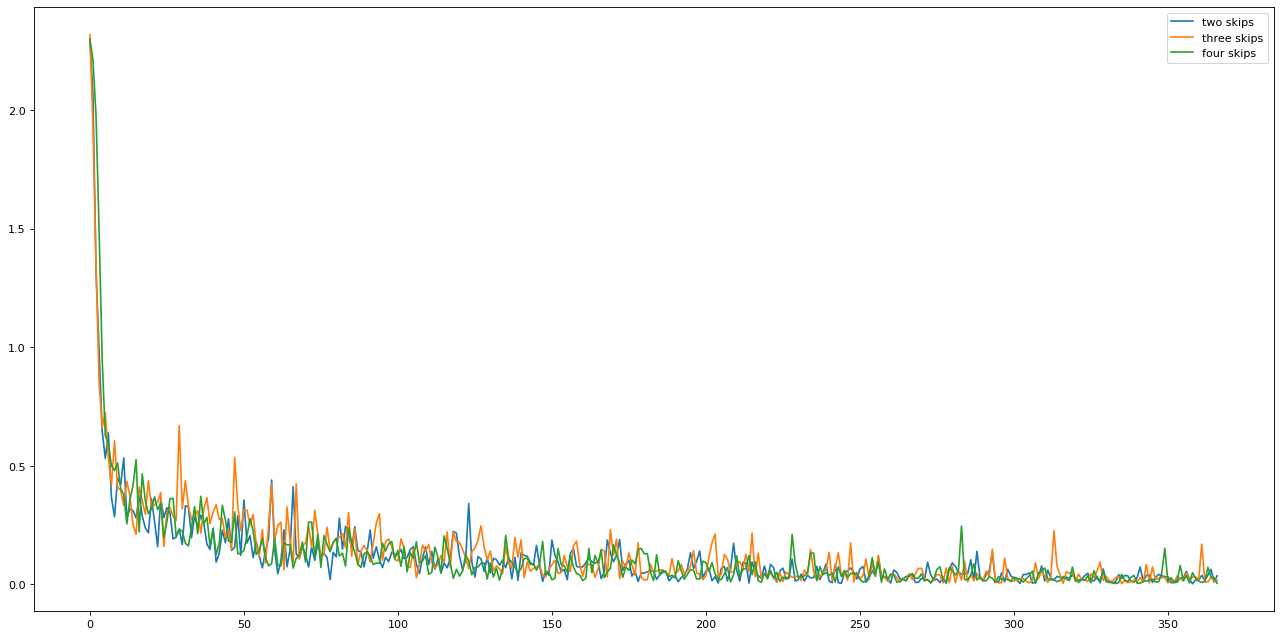

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


figure(figsize=(20, 10), dpi=80)
l1 = np.array(loss_model_two_skips)
l2 = np.array(loss_model_three_skips)
l3 = np.array(loss_model_four_skips)
iter_list = np.arange(367)
plt.plot(iter_list,l1,label = "two skips")
plt.plot(iter_list,l2,label = "three skips")
plt.plot(iter_list,l3,label = "four skips")
plt.legend()
plt.show()